#### Student Name:#### Student Name: Vivian
#### Student ID: A17442498


# Markov Chain, LZify

Instructions: 

* This notebook is an interactive assignment; please read and follow the instructions in each cell. 

* Cells that require your input (in the form of code or written response) will have 'Question #' above.

* After completing the assignment, please submit this notebook as a PDF.

* Make sure to mark the page with your solution for each problem on Gradescope. Any problems without the correct pages marked may receive a score of 0. 

## Markov-Based Chord Prediction

In music, certain chord transitions are more likely than others. This idea can be applied as Markov Models, where the first-order temporal relationships between the various chords are captured by the transition probability matrix $A$. 

If we consider only major and minor chords, there are a total of 24 chords in this model (12 major, from C through B, and 12 minor, from C through B), formalized as:

\begin{equation}
\label{eq:ChordReco:HMM:App:Spec:SetStates}
  \mathcal{A} = \{\mathbf{C},\mathbf{C}^\sharp,\ldots,\mathbf{B},\mathbf{Cm},\mathbf{Cm^\sharp},\ldots,\mathbf{Bm}\} 
\end{equation}

We use the notation $\alpha{i}\rightarrow\alpha{j}$ referring to the transition from state $\alpha{i}$ to state $\alpha{j}$, $i,j\in[1:24]$. For example, the coefficient $a_{1,2}$ expresses the 
probability for the transition $\alpha_{1}\rightarrow\alpha_{2}$ (corresponding to  $\mathbf{C}\rightarrow\mathbf{C}^\sharp$), whereas $a_{1,8}$ expresses the probability for $\alpha_{1}\rightarrow\alpha_{8}$  (corresponding to  $\mathbf{C}\rightarrow\mathbf{G}$). In real music, the change from a tonic to the dominant is much more likely
than transposing by one semitone, so that the probability $a_{1,8}$ should be much larger than $a_{1,2}$. The coefficients $a_{i,i}$ express the probability of staying in state $\alpha_{i}$ (i.e., $\alpha_{i}\rightarrow\alpha_{i}$), $i\in[1:24]$. These coefficients are also referred to as **self-transition** probabilities.

A transition probability matrix can be specified in many ways. For example, the matrix may be defined manually by a music expert based on rules from harmony theory. The most common approach is to generate such a matrix automatically 
by estimating the transition probabilities from labeled data. 

In the following exercise, you will create a Markov model by determining transition probabilities found in the music of the Beatles using bigrams (pairs of adjacent elements) in labeled frame sequences from a subset of the Beatles Corpus.

For this assignment, assume each row in the dataset represents a chord that has followed the chord on the previous row in a Beatles song. When parsing the file for your model, you may discard any chord references beyond key and major/minor quality. For example, if a row reads 'Bbm7', you would parse for the key (B-flat) and quality (minor), but discard the extra information that it is a 7th chord.  

In [1]:
!pip install mido
import numpy as np
import pandas as pd
from collections import Counter
from numpy.random import multinomial as randm
from numpy import where
import scipy.signal as si
import IPython.display as ipd
from matplotlib import patches
import matplotlib.pyplot as plt
import librosa
import scipy
import librosa.display as ld
import music21
from music21 import midi as midi21
from music21 import stream
#from jchord.progressions import ChordProgression, MidiConversionSettings
import copy
import time
from IPython.display import Audio, display


np.random.seed(42)

data = pd.read_csv('Liverpool_band_chord_sequence.csv')

def preprocess(df):
    df[df['chords'] == 'Bb'] = 'A#'  
    chords = ' '.join(map(str, df['chords']))
    return chords

data = preprocess(data)


def play(x):

    # Define the mapping between chord names and frequencies
    chord_mapping = {
    'C': [261.63, 329.63, 392.00],
    'C#': [277.18, 349.23, 415.30],
    'Db': [277.18, 349.23, 415.30],
    'D': [293.66, 369.99, 440.00],
    'D#': [311.13, 392.00, 466.16],
    'Eb': [311.13, 392.00, 466.16],
    'E': [329.63, 415.30, 493.88],
    'F': [349.23, 440.00, 523.25],
    'F#': [369.99, 466.16, 554.37],
    'Gb': [369.99, 466.16, 554.37],
    'G': [392.00, 493.88, 587.33],
    'G#': [415.30, 523.25, 622.25],
    'Ab': [415.30, 523.25, 622.25],
    'A': [440.00, 554.37, 659.26],
    'A#': [466.16, 587.33, 698.46],
    'Bb': [466.16, 587.33, 698.46],
    'B': [493.88, 622.25, 739.99],
    'Cm': [261.63, 311.13, 392.00],
    'Dbm': [277.18, 329.63, 415.30],
    'Dm': [293.66, 349.23, 440.00],
    'Ebm': [311.13, 369.99, 466.16],
    'Em': [329.63, 392.00, 493.88],
    'Fm': [349.23, 415.30, 523.25],
    'Gbm': [369.99, 440.00, 554.37],
    'Gm': [392.00, 466.16, 587.33],
    'Abm': [415.30, 493.88, 622.25],
    'Am': [440.00, 523.25, 659.26],
    'Bbm': [466.16, 554.37, 698.46],
    'Bm': [493.88, 587.33, 739.99]
    }

    # Define the chord progression
    chord_progression = x.split()

    # Define the duration of each chord (in seconds)
    chord_duration = 1.5

    # Set the sample rate (number of samples per second)
    sample_rate = 44100

    # Create an empty list to store the audio samples
    audio_samples = []

    # Generate the audio samples for each chord
    for chord_name in chord_progression:
        # Get the frequencies for the chord
        chord_freqs = chord_mapping[chord_name]

        # Generate sine waves for each note in the chord
        chord_wave = np.zeros(int(chord_duration * sample_rate))
        t = np.linspace(0, chord_duration, int(chord_duration * sample_rate), endpoint=False)
        for freq in chord_freqs:
            chord_wave += np.sin(2 * np.pi * freq * t)

        # Normalize the chord wave
        chord_wave /= np.max(chord_wave)

        # Append the chord wave to the audio samples list
        audio_samples.extend(chord_wave)

    # Convert the audio samples to a NumPy array
    audio_samples = np.array(audio_samples)

    # Play the chord progression in the Jupyter Notebook
    audio_jupyter = Audio(audio_samples, rate=sample_rate)

    display(audio_jupyter)


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


##### Question 1 (20 points)

Using the above data, generate a 24x24 matrix, where each matrix element (i,j) is the transition probability from chord i to chord j. 

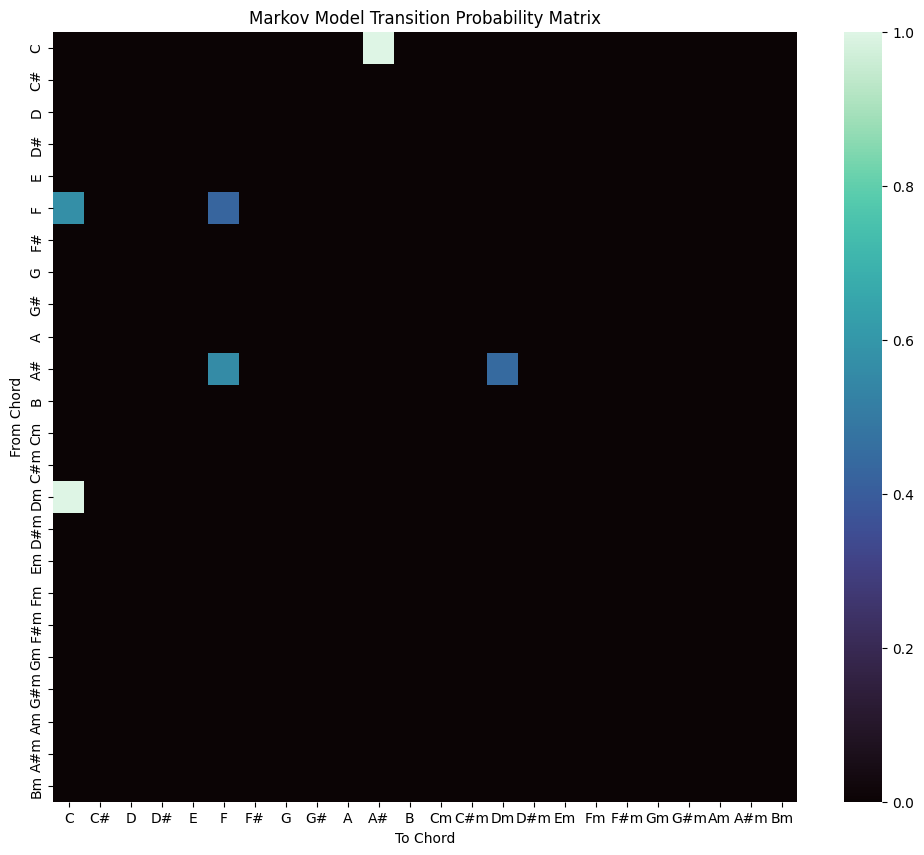

In [2]:
chord_list = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B',
              'Cm', 'C#m', 'Dm', 'D#m', 'Em', 'Fm', 'F#m', 'Gm', 'G#m', 'Am', 'A#m', 'Bm']

chord_to_index = {chord: i for i, chord in enumerate(chord_list)}

count_matrix = np.zeros((24, 24))

chord_sequence = data.split()

for i in range(len(chord_sequence) - 1):
    current_chord = chord_sequence[i]
    next_chord = chord_sequence[i + 1]
    if current_chord in chord_to_index and next_chord in chord_to_index:
        from_idx = chord_to_index[current_chord]
        to_idx = chord_to_index[next_chord]
        count_matrix[from_idx, to_idx] += 1

MM = np.zeros_like(count_matrix)
for i in range(24):
    total = np.sum(count_matrix[i])
    if total > 0:
        MM[i] = count_matrix[i] / total  
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(MM, xticklabels=chord_list, yticklabels=chord_list, cmap="mako")
plt.title("Markov Model Transition Probability Matrix")
plt.xlabel("To Chord")
plt.ylabel("From Chord")
plt.show()


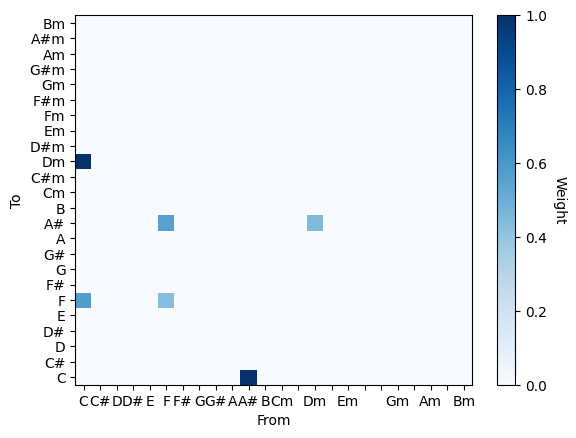

In [3]:
def plot_transition_matrix(A, ax=None, xlabel='State $a_j$', ylabel='State $a_i$', title='', clim=[-6, 0], cmap='gray_r'):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the transition matrix with a colorbar
    im = ax.imshow(A, origin = 'lower', aspect = 'auto',cmap='Blues')

    # Set the tick labels
    ax.set_xticks(np.arange(len(A)))
    ax.set_yticks(np.arange(len(A)))
    ax.set_xticklabels(np.arange(1, len(A) + 1))
    ax.set_yticklabels(np.arange(1, len(A) + 1))

    # Set the axis labels
    ax.set_xlabel('From')
    ax.set_ylabel('To')

    # Create a colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Set the colorbar label
    cbar.ax.set_ylabel('Weight', rotation=-90, va="bottom")

    chroma_label = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    chord_label_maj = chroma_label
    chord_label_min = [s + 'm' for s in chroma_label]
    chord_labels = chord_label_maj + chord_label_min
    chord_labels_squeezed = chord_labels.copy()
    for k in [13, 15, 17, 18, 20, 22]:
        chord_labels_squeezed[k] = ''
        
    plt.xticks(np.arange(24), labels=chord_labels_squeezed )
    plt.yticks(np.arange(24), labels=chord_labels)
    
    # Show the plot
    plt.show()    

plot_transition_matrix(MM)

##### Question 2 (10 points)

Using your MM, you will create your own 16-measure Beatles hits!
For your first song, beginning on C major, select each next chord by choosing the chord with the largest transition probability from the current chord.

Make sure your chord progression string is formatted like this: 'C Dm G C'

Otherwise, it may not play in the in-browser MIDI player. 

In [4]:
# Start from 'C'
current_chord = 'C'
progression = [current_chord]


for _ in range(15):
    current_idx = chord_to_index[current_chord]
    
    next_idx = np.argmax(MM[current_idx])
    next_chord = chord_list[next_idx]
    progression.append(next_chord)
    current_chord = next_chord 

# Format the progression into a space-separated string
my_first_beatles_hit = ' '.join(progression)

print(my_first_beatles_hit)
play(my_first_beatles_hit)


C A# F C A# F C A# F C A# F C A# F C


##### Question 3 (10 points)

For your second song, beginning on C major, select each next chord at random according to the probabilities of your MM.
For example, if C major transitions to G major with probability .5, F major with probability .25, and D minor with probability .25, then your next chord should be selected randomly from (G, F, Dm) with probability of selection (.5, .25, .25) respectively. 

In [5]:
# Start from 'C'
current_chord = 'C'
progression_random = [current_chord]

# Generate 15 more chords (16 total)
for _ in range(15):
    current_idx = chord_to_index[current_chord]
    probs = MM[current_idx]

    # Normalize to ensure it's a probability distribution
    probs /= probs.sum()

    # Sample next chord index based on the probabilities
    next_idx = np.random.choice(np.arange(24), p=probs)
    next_chord = chord_list[next_idx]
    progression_random.append(next_chord)
    current_chord = next_chord

# Format the progression into a space-separated string
my_second_beatles_hit = ' '.join(progression_random)

print(my_second_beatles_hit)
play(my_second_beatles_hit)


C A# Dm C A# F C A# Dm C A# F F F C A#


## LZify: Applying Universal Prediction to Musical Style

LZify was the first algorithmic learning method to create a style immitation from a dictionary of motifs of variable size. It is based on the Lempel-Ziv compression method. Because the viriable context (motif) size that is used for perdiction of the next note, the method became also know as Variable Memory Markov model. Strictly speaking, is not a correct term, but LZ prediciton is known to perform asymptotically as good as any finite Markov model, so the terminology is partially justified. 

In this section, you will implement the Incremental Parsing (IP) from the Lempel Ziv LZ78 method for creating a dictionary of motifs. These motifs are later used to generate new sequences resembling the input sequence.

Please read the algorithm in Assayag, Dubnov, and Delerue's "Guessing the Composer’s Mind" (available at https://pdfs.semanticscholar.org/0181/236e1b417c8dd5dddd1f919583893f7a9026.pdf). 

The IPMotif function should compute the motif dictionary discovered in the text. It uses Incremental Parsing method to parse the text into unseen motifs.

##### Question 4 (20 points)

In [6]:
def IPMotif(text):
    dictionary = {}
    prefix = ""
    index = 1

    for symbol in text:
        candidate = prefix + symbol
        if candidate not in dictionary:
            dictionary[candidate] = index
            index += 1
            prefix = ""
        else:
            prefix = candidate

    return dictionary


The text below contains an excerpt of Beethoven's Fur Elise, written as MML (Music Macro Language). MML is used to represent musical melodies as text. 

You can read more about MML syntax here: https://en.wikipedia.org/wiki/Music_Macro_Language

You can play with MML in this webapp: https://msxplay.com/editor.html

Try playing the text from the cell below in the webapp to hear sample output. 

In [7]:
;[name=scc lpf=1]

#opll_mode 1

#tempo 150

#title { "Output"}

@s00 = { 2B343E3F3F3F3F3F3F3F3F3F3F3F3F3F3F3F3F3F3F3F3F3F3F403E2DC0CD273A }

@s01 = { C3CFD3D0D1DAE6F2000A27383D3E3C3E403F3B352A0EF8EEEFF4E9DDD4CCC6C0 }

@s02 = { 3E383230302F2B200DF6E0D0C7C5C4C4C3C1C0C6D5E9FB050B0C0D111B2A3840 }

@s03 = { CCC7C3C0C1C4CDDAED021A2D3A403E3A332C251D160F0903FDF7F0EAE4DED7D1 }

@s04 = { 3D403D36302D303A3F24E0C2DDE6D7CBC3C0C3CAD0D3D0C6C1DC203E231A2935 }

@s05 = { 05FFF2DFCCC0CE003932DCD127401AF9E8E0DDDCDEE2E5ECF2F900030A0C0E0C }

@s06 = { F5F5F1ECE5DDD4CAC0C1D708403A0E050C0703020301000000FFFFFFFDFDFBF8 }

@s07 = { 003F3F3F3F3F3F3F402BF6D2C6C4C6CACCC7C0C8EA1E3E3F3F3F3F3F3F3F3F3F }

@s08 = { 00242423211C18110B0600FBF6F3F0F0F2F7FF0A1A304758552FEAB0ADD6FF16 }

@s09 = { B2252524221D19110C0600FAF6F2F0F0F2F7FF0A1B31495A5730E9ADAAD5FF16 }

@s10 = { D13232312F272118100801F8F2EDEAEAECF4FE0E2543637B7642E1908BC5FF1E }

@s11 = { BD252625231D19120C0600FAF6F2F0EFF1F7FF0A1C324A5C5931E9ACA9D4FF17 }

@s12 = { E45B5C5955483D2C1D1002F2E6DDD7D7DCE9FC19447BB5E0D878C8332B94FD37 }

@s13 = { FF131313120F0D09060300FDFBF9F8F8F9FC00050E1A262F2D19F4D5D3EA000B }

@s14 = { 191919181713100C080400FCF9F7F5F5F7FAFF061221313D3A20F1C9C6E3000F }

;      Mode,nFreq, AL, AR, DR, SL, SR, RR
@r0 = {   0,    0,128, 32, 12,128,  2,  4}
@r1 = {   0,    0,255,255, 12,128,  2,  4}

; C G F Em /C

4567 v12@0@r1 l4o4q5

4  MGSC MML compiler version 1.11
Copyright(c) 1992-94 by Ain

Compile complete

track :  0  ( 1016)  (  528)  (  488)
track :  1  (    0)  (    0)  (    0)
track :  2  (    0)  (    0)  (    0)
track :  3  (    0)  (    0)  (    0)
track :  4  ( 1016)  (    9)  ( 1007)
track :  5  ( 1016)  (    9)  ( 1007)
track :  6  ( 1016)  (    9)  ( 1007)
track :  7  ( 1016)  (    9)  ( 1007)
track :  8  (    0)  (    0)  (    0)
track :  9  (    0)  (    0)  (    0)
track : 10  (    0)  (    0)  (    0)
track : 11  (    0)  (    0)  (    0)
track : 12  (    0)  (    0)  (    0)
track : 13  (    0)  (    0)  (    0)
track : 14  (    0)  (    0)  (    0)
track : 15  (    0)  (    0)  (    0)
-------------------------------------
total :       5080      564     4516 
Save complete

SyntaxError: invalid decimal literal (3442044763.py, line 9)

As another option to listen to your generated MML text played with a piano instead of the synthetic sound on MSXplay, go to https://archeagemmllibrary.com/a-ha-take-on-me/

In your browser, find the option to Inspect Element, and edit the MML text to instead contain your composition.

Be sure to add a prefix of t180 to your MML output in order to set the tempo. 
(Special thanks to Alex Simonyan for this in-browser MML hack)

In [8]:
text = 'o6ed+ed+ec-dc>aceabeg+bb+e<ed+ed+ec-dc>aceabe<c>bab<cde>g<fed>f<edc>e<dc>be<eeed+ed+ec-dc>aceabeg+bb+e<ed+ed+ec-dc>aceabe<c>ba'
dict1 = IPMotif(text)
print(dict1)

{'o': 1, '6': 2, 'e': 3, 'd': 4, '+': 5, 'ed': 6, '+e': 7, 'c': 8, '-': 9, 'dc': 10, '>': 11, 'a': 12, 'ce': 13, 'ab': 14, 'eg': 15, '+b': 16, 'b': 17, '+e<': 18, 'ed+': 19, 'ed+e': 20, 'c-': 21, 'dc>': 22, 'ac': 23, 'ea': 24, 'be': 25, '<': 26, 'c>': 27, 'ba': 28, 'b<': 29, 'cd': 30, 'e>': 31, 'g': 32, '<f': 33, 'ed>': 34, 'f': 35, '<e': 36, 'dc>e': 37, '<d': 38, 'c>b': 39, 'e<': 40, 'ee': 41, 'ed+ed': 42, '+ec': 43, '-d': 44, 'c>a': 45, 'cea': 46, 'beg': 47, '+bb': 48, '+e<e': 49, 'd+': 50, 'ed+ec': 51, '-dc': 52, '>a': 53, 'ceab': 54, 'e<c': 55, '>b': 56}


Next, implement the IPContinuation and Normalize functions. 
The IPContinuation function transforms the IPMotif dictionary into a tree-like representation to allow finding continuations for new  motifs. The Normalize function turns the counters in every element of the IPContinuation dictionary into probabilities. 

##### Question 5 (20 points)

In [9]:
def IPContinuation(dict1):

    dict2 = {}

    for motif in dict1.keys():
        for i in range(1, len(motif)):
            prefix = motif[:i]
            next_char = motif[i]

            if prefix not in dict2:
                dict2[prefix] = {}

            if next_char in dict2[prefix]:
                dict2[prefix][next_char] += 1
            else:
                dict2[prefix][next_char] = 1

    return dict2


##### Question 6 (10 points)

In [10]:
def Normalize(dict2):
    """Turns the counters in every element of dict2 to probabilities."""

    for prefix in dict2:
        total = sum(dict2[prefix].values())
        for key in dict2[prefix]:
            dict2[prefix][key] /= total

    return dict2


In [11]:
dict2 = IPContinuation(dict1)
print(dict2)

{'e': {'d': 6, 'g': 1, 'a': 1, '>': 1, '<': 2, 'e': 1}, '+': {'e': 4, 'b': 2}, 'd': {'c': 3, '+': 1}, 'c': {'e': 3, '-': 1, '>': 3, 'd': 1}, 'a': {'b': 1, 'c': 1}, '+e': {'<': 2, 'c': 1}, 'ed': {'+': 4, '>': 1}, 'ed+': {'e': 3}, 'dc': {'>': 2}, 'b': {'e': 2, 'a': 1, '<': 1}, '<': {'f': 1, 'e': 1, 'd': 1}, 'dc>': {'e': 1}, 'c>': {'b': 1, 'a': 1}, 'ed+e': {'d': 1, 'c': 1}, '-': {'d': 2}, 'ce': {'a': 2}, 'be': {'g': 1}, '+b': {'b': 1}, '+e<': {'e': 1}, '-d': {'c': 1}, '>': {'a': 1, 'b': 1}, 'cea': {'b': 1}, 'e<': {'c': 1}}


Generting a new sequence is done by traversing the IPContinuation tree and selecting possible branches according to their weights. If motif is not found, its last symbol is removed and the process is repeated for a shorter motif.

In [ ]:
def IPGenerate(n,dict2):
    p = 0
    out = ""
    for k in range(n):
        while True:
            context = out[-p:]
            if context in dict2:
                prob = [tup[1] for tup in dict2[context]]
                conti = where(randm(1,prob))[0][0]
                cont = dict2[context][conti][0]
                out = out + cont
                break
            else:                      
                p = p-1
    return out
out = IPGenerate(92,dict2)
print(out)

##### Question 7 (10 points)

Paste your output in the online MML player, and listen to your piece. Do you hear elements of Fur Elise in your composition? What are some of the differences in the output from the original? 

``` Your response here ``` Yes, I do hear elements of Für Elise in my generated composition. The overall melodic contour and motif repetitions are somewhat preserved, which makes parts of it recognizable. However, there are clear differences from the original. The timing and phrasing may sound less structured due to the algorithmic generation.This is expected because the model is imitating based on learned motifs, not on higher-level musical form or dynamics.

A few important points:
1. The method captures the "texture" of the language but not it's meaning.
2. We could parse a new text using IPMotifs from two languages, then count the length and number of motifs in order to decide what was the language of the new text.
3. In order to use this method with musical information, we need first to translate audio to features, or in case of polyphonic midi change this into some proper representation. One possibility is using virtual fundamental or chroma for harmony, or some other specialized representation to capture repetition in terms of other specific musical properties.